<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/code/identification/species/transformer_runs/run_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
# Hyperparameters
learning_rate = 1E-4 #@param {type:"integer"}
batch_size = 64 # @param {type:"integer"}
epochs = 2000 # @param {type:"integer"}

In [87]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import drive
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

drive.mount('/content/drive')
os.listdir('/content/drive/My Drive')

path = ['drive', 'MyDrive', 'AI', 'fish', 'REIMS_data.xlsx']
path = os.path.join(*path)

class CustomDataset(Dataset):

    def __init__(self, samples, labels):
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor([np.array(ys) for ys in labels], dtype=torch.float32)

        # Normalize the features to be between in [0,1]
        self.samples = F.normalize(self.samples, dim = 0)

        # full_batch_size = self.samples.shape[0]  # Get the batch size
        # in_channels = 1  # The number of channels in each item
        # sequence_length = self.samples[0].shape[0]  # Get the sequence length
        # # Reshape the input data
        # self.samples = self.samples.view(full_batch_size, in_channels, sequence_length)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
# Onehot encoding for the class labels, e.g. [0,1] for Hoki, [1,0] for Mackeral.
y = data['m/z'].apply(lambda x: [0,1] if 'H' in x else [1,0])
y = np.array(y)

# Evaluation parameters.
train_split = 0.8
val_split = 0.5 # 1/2 of 20%, validation and test, 10% and 10%, respectively.
# print(f"[DEBUG] train_split, val_split, test_split: ({train_split},{val_split},{test_split})")

# Step 2: Split your dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=(1-train_split))#, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_split)#, random_state=42)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1-train_split), random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_split, random_state=42)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

assert train_dataset.samples.shape[0] == train_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert val_dataset.samples.shape[0] == val_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert test_dataset.samples.shape[0] == test_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."

# Step 4: Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# calculate steps per epoch for training and validation set
train_steps = len(train_loader.dataset) // batch_size
val_steps = len(val_loader.dataset) // batch_size
# when batch_size greater than dataset size, avoid division by zero.
train_steps = max(1, train_steps)
val_steps = max(1, val_steps)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Reading the dataset.


In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention1D(nn.Module):
    def __init__(self, input_dim, num_heads):
        """ Transformer architecture (Vaswani 2017) """
        super(MultiHeadAttention1D, self).__init__()
        assert input_dim % num_heads == 0
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.fc_out = nn.Linear(input_dim, input_dim)

    def forward(self, query, key, value, mask=None):
        """ Attention (Vaswani 2017) """
        batch_size = query.shape[0]

        Q = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Energy-based models (Goodfellow 2016)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(energy, dim=-1)

        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.input_dim)

        x = self.fc_out(x)
        return x

class FeedForward1D(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super(FeedForward1D, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        # Dropout (Hinton 2012, Srivastava 2014)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # GELU (Hendrycks 2016)
        x = F.gelu(self.fc1(x))
        # Dropout (Hinton 2012, Srivastava 2014)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class EncoderLayer1D(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, dropout=0.1):
        super(EncoderLayer1D, self).__init__()
        # Attention (Vaswani 2017)
        self.self_attention = MultiHeadAttention1D(input_dim, num_heads)
        self.feed_forward = FeedForward1D(input_dim, hidden_dim)
        # Dropout (Hinton 2012, Srivastava 2014)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        # Layer normalization (Ba 2016)
        # Pre-norm formulation (Karpathy 2023)
        self.layer_norm1 = nn.LayerNorm(input_dim)
        self.layer_norm2 = nn.LayerNorm(input_dim)

    def forward(self, x, mask):
        """ Attention mechamism (Vaswani 2017)"""
        # Layer normalization (Ba 2016)
        # Pre-norm formulation (Karpathy 2023)
        x = self.layer_norm1(x)
        attention = self.self_attention(x, x, x, mask)
        # Residual connections (He 2016)
        x = x + self.dropout1(attention)
        x = self.layer_norm2(x)
        feed_forward_out = self.feed_forward(x)
        # Dropout (Hinton 2012, Srivastava 2014)
        x = x + self.dropout2(feed_forward_out)
        return x

class TransformerEncoder1D(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, hidden_dim, dropout=0.1):
        """ Transformer (Vaswani 2017) """
        super(TransformerEncoder1D, self).__init__()
        # A stacked auto-encoder (Vaswani 2017)
        self.layers = nn.ModuleList([EncoderLayer1D(input_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Transformer1D(nn.Module):
        """
        References:
        1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez,
            A. N., ... & Polosukhin, I. (2017).
            Attention is all you need.
            Advances in neural information processing systems, 30.
        2. He, K., Zhang, X., Ren, S., & Sun, J. (2016).
            Deep residual learning for image recognition.
            In Proceedings of the IEEE conference on
            computer vision and pattern recognition (pp. 770-778).
        3. LeCun, Y. (1989). Generalization and network design strategies.
            Connectionism in perspective, 19(143-155), 18.
        4. LeCun, Y., Boser, B., Denker, J., Henderson, D., Howard,
            R., Hubbard, W., & Jackel, L. (1989).
            Handwritten digit recognition with a back-propagation network.
            Advances in neural information processing systems, 2.
        5. LeCun, Y., Boser, B., Denker, J. S., Henderson, D., Howard, R. E.,
            Hubbard, W., & Jackel, L. D. (1989).
            Backpropagation applied to handwritten zip code recognition.
            Neural computation, 1(4), 541-551.
        6. Hendrycks, D., & Gimpel, K. (2016).
            Gaussian error linear units (gelus).
            arXiv preprint arXiv:1606.08415.
        7. Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016).
            Layer normalization. arXiv preprint arXiv:1607.06450.
        8. Srivastava, N., Hinton, G., Krizhevsky, A.,
            Sutskever, I., & Salakhutdinov, R. (2014).
            Dropout: a simple way to prevent neural networks from overfitting.
            The journal of machine learning research, 15(1), 1929-1958.
        9. Hinton, G. E., Srivastava, N., Krizhevsky, A., Sutskever,
            I., & Salakhutdinov, R. R. (2012).
            Improving neural networks by preventing co-adaptation of feature detectors.
            arXiv preprint arXiv:1207.0580.
        10. Glorot, X., & Bengio, Y. (2010, March).
            Understanding the difficulty of training deep feedforward neural networks.
            In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).
            JMLR Workshop and Conference Proceedings.
        11. Loshchilov, I., & Hutter, F. (2017).
            Decoupled weight decay regularization.
            arXiv preprint arXiv:1711.05101.
        12. Goodfellow, Ian, Yoshua Bengio, and Aaron Courville.
            Deep learning. MIT press, 2016.
        13. Morgan, N., & Bourlard, H. (1989).
            Generalization and parameter estimation in feedforward nets:
            Some experiments. Advances in neural information processing systems, 2.
        14. Karpathy, Andrej (2023)
            Let's build GPT: from scratch, in code, spelled out.
            YouTube https://youtu.be/kCc8FmEb1nY?si=1vM4DhyqsGKUSAdV
        """
        def __init__(self, input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout=0.1):
            super(Transformer1D, self).__init__()
            self.encoder = TransformerEncoder1D(input_dim, num_layers, num_heads, hidden_dim, dropout)
            self.fc = nn.Linear(input_dim, output_dim)

        def forward(self, x, mask):
            x = self.encoder(x, mask)
            x = self.fc(x[:, 0, :])
            return x

[INFO] Training the network
[INFO] Epoch 1/50, Train Loss: 0.6299, Train Acc: 0.6631, Val Loss: 0.6610, Val Acc: 0.5217
[INFO] Epoch 2/50, Train Loss: 0.5662, Train Acc: 0.6738, Val Loss: 0.5585, Val Acc: 0.5652
[INFO] Epoch 3/50, Train Loss: 0.5209, Train Acc: 0.7166, Val Loss: 0.4607, Val Acc: 0.6522
[INFO] Epoch 4/50, Train Loss: 0.4181, Train Acc: 0.8610, Val Loss: 0.3971, Val Acc: 0.7391
[INFO] Epoch 5/50, Train Loss: 0.3775, Train Acc: 0.8770, Val Loss: 0.3509, Val Acc: 0.7391
[INFO] Epoch 6/50, Train Loss: 0.3349, Train Acc: 0.8663, Val Loss: 0.3004, Val Acc: 0.8696
[INFO] Epoch 7/50, Train Loss: 0.2933, Train Acc: 0.9037, Val Loss: 0.2581, Val Acc: 0.9565
[INFO] Epoch 8/50, Train Loss: 0.2757, Train Acc: 0.9144, Val Loss: 0.2177, Val Acc: 1.0000
[INFO] Epoch 9/50, Train Loss: 0.2574, Train Acc: 0.9251, Val Loss: 0.1758, Val Acc: 1.0000
[INFO] Epoch 10/50, Train Loss: 0.1958, Train Acc: 0.9840, Val Loss: 0.1412, Val Acc: 1.0000
[INFO] Epoch 11/50, Train Loss: 0.1633, Train Acc: 

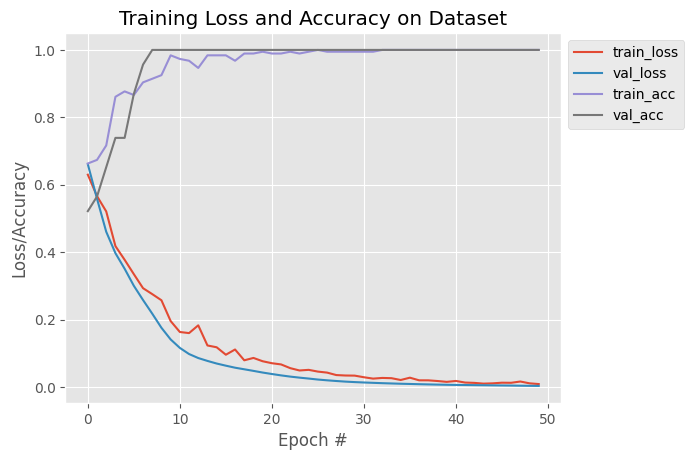

[INFO] total time taken to train the model: 12.65s


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs, mask=None)  # Assuming no masking is needed for now

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        # print(f"[DEBUG] predicted: {predicted}\n targets: {targets.argmax(1)}")
        correct_predictions += (predicted == targets.argmax(1)).sum().item()
        total_samples += targets.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs, mask=None)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets.argmax(1)).sum().item()
            total_samples += targets.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[INFO] Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Early stopping (Morgan 1989)
        # if train_accuracy == 1 and val_accuracy == 1:
        #     break

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.plot(train_accuracies, label="train_acc")
    plt.plot(val_accuracies, label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.savefig("model_accuracy.png")
    plt.show()

    return train_losses, train_accuracies, val_losses, val_accuracies

# Define your dataset and dataloaders
# train_dataloader = ...
# val_dataloader = ...

# Define hyperparameters
input_dim = 1023  # Example: size of input sequence
output_dim = 2  # Example: number of output classes
num_layers = 3
num_heads = 3
hidden_dim = 128
dropout = 0.2
learning_rate = 1e-5
num_epochs = 50

# Initialize the model, criterion, and optimizer
model = Transformer1D(input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout)
criterion = nn.CrossEntropyLoss()
# AdamW [10]
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("[INFO] Training the network")
startTime = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

In [90]:
model.eval()
# switch off autograd
with torch.no_grad():
    # loop over the test set
    datasets = [("train", train_loader), ("validation", val_loader), ("test", test_loader)]
    for name, dataset in datasets:
        for (x,y) in dataset:
            (x,y) = (x.to(device), y.to(device))
            y_true = y
            pred = model(x, mask=None)
            # print(f"pred: {pred}, y: {y}")
            test_correct = (pred.argmax(1) == y.argmax(1)).sum().item()
            print(f"[INFO] {name} accuracy {test_correct} / {len(x)}")

[INFO] train accuracy 64 / 64
[INFO] train accuracy 64 / 64
[INFO] train accuracy 59 / 59
[INFO] validation accuracy 23 / 23
[INFO] test accuracy 24 / 24
